## The purpose of this notebook is merely to plot what the helper functions (dropper, faker and shaker) do. The architecture and training stuff is found in the notebook called "NEW DROSFA Network".

In [6]:
# read the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

grid = pd.read_pickle("outputs_in_instab_strip.pkl")

In [7]:
print(grid.columns)

Index(['F_l_0', 'F_l_1', 'F_l_2', 'O1_l_0', 'O1_l_1', 'O1_l_2', 'O2_l_0',
       'O2_l_1', 'O2_l_2', 'O3_l_0', 'O3_l_1', 'O3_l_2', 'O4_l_0', 'O4_l_1',
       'O4_l_2', 'O5_l_0', 'O5_l_1', 'O5_l_2', 'O6_l_0', 'O6_l_1', 'O6_l_2',
       'O7_l_0', 'O7_l_1', 'O7_l_2', 'O8_l_0', 'O8_l_1', 'O8_l_2', 'O9_l_0',
       'O9_l_1', 'O9_l_2', 'delta_nu'],
      dtype='object')


In [8]:
# then we have to first create the X and y matrices.

l_values = [0, 1, 2] 
l_columns = {l: [col for col in grid.columns if col.endswith(f"_l_{l}")] for l in l_values}

X_frequencies = np.hstack([grid[l_columns[l]].values for l in l_values])  
delta_nu_values = grid["delta_nu"].values[:, np.newaxis] 
mod_frequencies = X_frequencies % delta_nu_values 

X = np.stack((X_frequencies, mod_frequencies), axis=-1)
y = np.hstack([np.full_like(grid[l_columns[l]].values, l) for l in l_values])  

print(f"X-matrix shape: {X.shape}")
print(f"y-matrix shape: {y.shape}") 

X-matrix shape: (153314, 30, 2)
y-matrix shape: (153314, 30)


In [9]:
from sklearn.model_selection import train_test_split
import torch

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y contains class labels

# Split the data (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])


In [10]:
size = 10000 # or for all models it would be: X_train.shape[0]
inpt = X_train[:size]
print(inpt.shape)

torch.Size([10000, 30, 2])


### Model definition

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PointNet(nn.Module):
    def __init__(self, num_classes=4, point_dimension=2):# dropout=0.3):
        super(PointNet, self).__init__()

        a = 5
        nfeat = 128 
        self.conv_1_a = nn.Conv1d(1, nfeat, kernel_size=a, padding=2)
        self.conv_1_b = nn.Conv1d(1, nfeat, kernel_size=a, padding=2)
        self.conv_2 = nn.Conv1d(nfeat, nfeat, kernel_size=a, padding=2)
        self.bn_1 = nn.BatchNorm1d(nfeat)
        self.bn_2 = nn.BatchNorm1d(nfeat)

    def forward(self, x, plot=False):
        batch_size, num_points, _ = x.shape

        x_freq = x[:, :, 0].unsqueeze(1)
        x_modnu = x[:, :, 1].unsqueeze(1)
        x_freq = F.pad(x_freq, (1, 1), mode='replicate')
        x_modnu = F.pad(x_modnu, (1, 1), mode='circular')
        x_freq_feat = self.conv_1_a(x_freq)
        x_modnu_feat = self.conv_1_b(x_modnu)
        x = x_freq_feat + x_modnu_feat
        x = F.relu(self.bn_1(x))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = nn.MaxPool1d(num_points)(x)
        x = x.view(batch_size, -1)
        return x


class SegmentationPointNet(nn.Module):
    def __init__(self, num_classes=4, point_dimension=2):# dropout=0.3):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(num_classes=num_classes, point_dimension=point_dimension)

        nhidden = 16
        nfeat = 128 
        self.fc_1 = nn.Linear(nfeat + 2, nhidden)
        #self.dropout = nn.Dropout(p=dropout)
        self.fc_2 = nn.Linear(nhidden, 4)

    def forward(self, x):
        global_features = self.base_pointnet(x)
        global_features = global_features.unsqueeze(1)
        global_features = global_features.repeat(1, x.shape[1], 1)
        x = torch.cat((x, global_features), dim=2)
        x = F.relu(self.fc_1(x))
        #x = self.dropout(x)

        return F.log_softmax(self.fc_2(x), dim=2)

In [12]:
model = SegmentationPointNet(num_classes=4, point_dimension=2)
loss = nn.NLLLoss()

In [8]:
out = model(inpt)

### Helper functions and training setup
#### Only dropper

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


def apply_data_dropper(x, y, dropout_prob=0.3):
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()

    x_dropped = x.clone()
    x_dropped[mask == 0] = 0.0

    y_dropped = y.clone()
    y_dropped[mask == 0] = 3  # new label for dropped points = 3

    drop_stats = mask.shape[1] - mask.sum(dim=1)
    return x_dropped, y_dropped, mask, drop_stats


Nepoch = 150
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size(0) // nbatches

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean")  # ← REMOVED ignore_index
history_train, history_test = [], []
all_drop_counts = []
inpt_test = inpt
target_test = y_train[:inpt.shape[0]]

for epoch in range(Nepoch):
    model.train()

    for i in range(nbatches):
        optimizer.zero_grad()

        x_batch = inpt[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        x_dropped, y_dropped, mask, drop_stats = apply_data_dropper(x_batch, y_batch, dropout_prob=0.3)
        all_drop_counts.extend(drop_stats.cpu().tolist())

        seg_output = model(x_dropped)
        cost = loss_fn(seg_output.permute(0, 2, 1), y_dropped)

        cost.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        seg_out_test = model(inpt_test)
        cost_test = loss_fn(seg_out_test.permute(0, 2, 1), target_test)

    history_train.append(float(cost))
    history_test.append(float(cost_test))
    pred_classes = seg_out_test.argmax(dim=2)
    mask_valid = target_test != 3
    acc = (pred_classes[mask_valid] == target_test[mask_valid]).float().mean()
    print(f"Accuracy = {acc:.4f}")

    print(f"Epoch {epoch}: Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}")

Accuracy = 0.4166
Epoch 0: Train Loss = 0.7720, Test Loss = 1.0839
Accuracy = 0.4666
Epoch 1: Train Loss = 0.7176, Test Loss = 1.0191
Accuracy = 0.4411
Epoch 2: Train Loss = 0.6912, Test Loss = 0.9716
Accuracy = 0.4528
Epoch 3: Train Loss = 0.6573, Test Loss = 0.9460
Accuracy = 0.4899
Epoch 4: Train Loss = 0.6562, Test Loss = 0.9256
Accuracy = 0.5079
Epoch 5: Train Loss = 0.6297, Test Loss = 0.9018
Accuracy = 0.5203
Epoch 6: Train Loss = 0.6110, Test Loss = 0.8511
Accuracy = 0.5742
Epoch 7: Train Loss = 0.5770, Test Loss = 0.8016
Accuracy = 0.6515
Epoch 8: Train Loss = 0.5500, Test Loss = 0.7595
Accuracy = 0.6800
Epoch 9: Train Loss = 0.5137, Test Loss = 0.7262
Accuracy = 0.6868
Epoch 10: Train Loss = 0.4972, Test Loss = 0.6982
Accuracy = 0.6662
Epoch 11: Train Loss = 0.4846, Test Loss = 0.6852
Accuracy = 0.7074
Epoch 12: Train Loss = 0.4598, Test Loss = 0.6673
Accuracy = 0.6945
Epoch 13: Train Loss = 0.4638, Test Loss = 0.6499
Accuracy = 0.7602
Epoch 14: Train Loss = 0.4420, Test Loss

KeyboardInterrupt: 

In [ ]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()

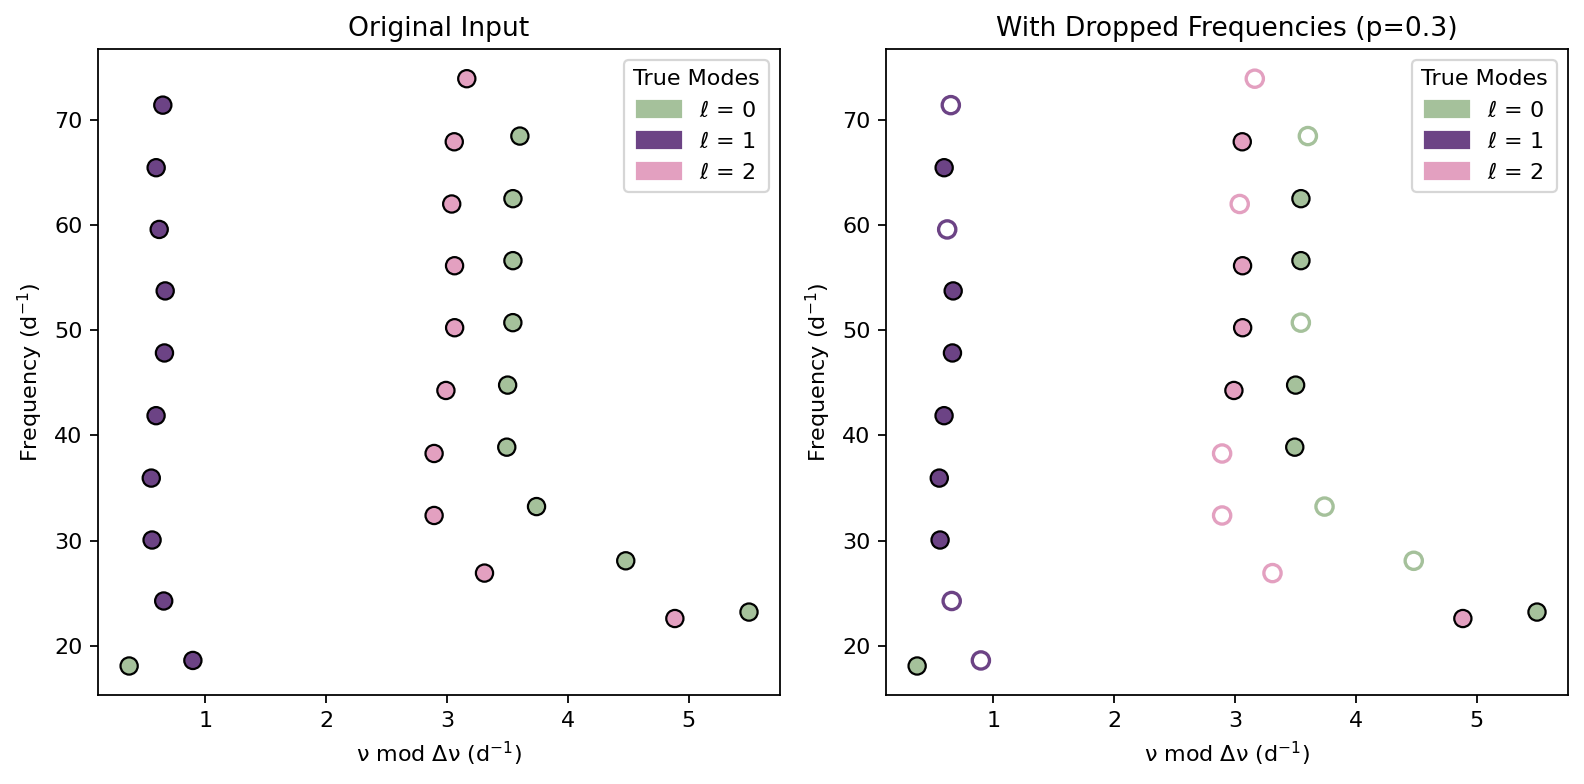

In [14]:
import torch
import matplotlib.pyplot as plt
import random
import matplotlib.patches as mpatches

def apply_data_dropper(x, y, dropout_prob=0.3):
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()
    x_dropped = x.clone()
    x_dropped[mask == 0] = 0.0
    y_dropped = y.clone()
    y_dropped[mask == 0] = 3  # use 3 for dropped class
    drop_stats = mask.shape[1] - mask.sum(dim=1)
    return x_dropped, y_dropped, mask, drop_stats

def plot_dropped_example(inpt, y_train, dropout_prob=0.5):
    rand_idx = random.randint(0, inpt.shape[0] - 1)
    x_example = inpt[rand_idx:rand_idx+1]
    y_example = y_train[rand_idx:rand_idx+1]
    x_dropped, y_dropped, mask, _ = apply_data_dropper(x_example, y_example, dropout_prob=dropout_prob)

    x_orig = x_example.squeeze(0)
    x_drop = x_dropped.squeeze(0)
    y_orig = y_example.squeeze(0)
    y_drop = y_dropped.squeeze(0)
    mask = mask.squeeze(0)

    color_map = {
        0: '#a5c19b',  # greenish
        1: '#6c4385',  # purple
        2: '#e3a0c0',  # pink
        3: '#aaaaaa',  # gray for dropped
    }

    xlim = [x_orig[:, 1].min().item(), x_orig[:, 1].max().item()]
    ylim = [x_orig[:, 0].min().item(), x_orig[:, 0].max().item()]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=160)

    # Original Input
    axs[0].scatter(
        x_orig[:, 1], x_orig[:, 0],
        c=[color_map[int(l.item())] for l in y_orig],
        edgecolors='black', s=60
    )
    legend_handles = [
        mpatches.Patch(color=color_map[i], label=rf"$\ell$ = {i}") for i in range(3)
    ]
    axs[0].legend(handles=legend_handles, loc='best', title="True Modes")
    
    axs[0].set_title("Original Input")
    axs[0].set_xlabel("ν mod Δν (d$^{-1}$)")
    axs[0].set_ylabel("Frequency (d$^{-1}$)")
    #axs[0].set_xlim(xlim)
    #axs[0].set_ylim(ylim)

    # Dropped Input
    keep_mask = mask.bool()
    drop_mask = ~keep_mask

    # Plot kept frequencies
    axs[1].scatter(
        x_drop[keep_mask, 1], x_drop[keep_mask, 0],
        c=[color_map[int(y_drop[i].item())] for i in range(len(y_drop)) if keep_mask[i]],
        edgecolors='black', s=60
    )

    # Plot dropped frequencies as hollow circles
    for i in range(len(x_drop)):
        if drop_mask[i]:
            true_label = int(y_orig[i].item())
            axs[1].scatter(
                x_orig[i, 1].item(), x_orig[i, 0].item(),
                facecolors='none',
                edgecolors=color_map[true_label],
                linewidths=1.5,
                s=60,
                marker='o'
            )

    axs[1].set_title(f"With Dropped Frequencies (p={dropout_prob})")
    axs[1].set_xlabel("ν mod Δν (d$^{-1}$)")
    axs[1].set_ylabel("Frequency (d$^{-1}$)")
    #axs[1].set_xlim(xlim)
    #axs[1].set_ylim(ylim)
    legend_handles = [
        mpatches.Patch(color=color_map[i], label=rf"$\ell$ = {i}") for i in range(3)
    ]
    axs[1].legend(handles=legend_handles, loc='best', title="True Modes")

    plt.tight_layout()
    plt.savefig("dropper_example_mindset.pdf", bbox_inches="tight")
    plt.show()

plot_dropped_example(inpt, y_train, dropout_prob=0.3)

Original Δν from grid: 4.0401 d⁻¹
Recalculated Δν: 2.2843


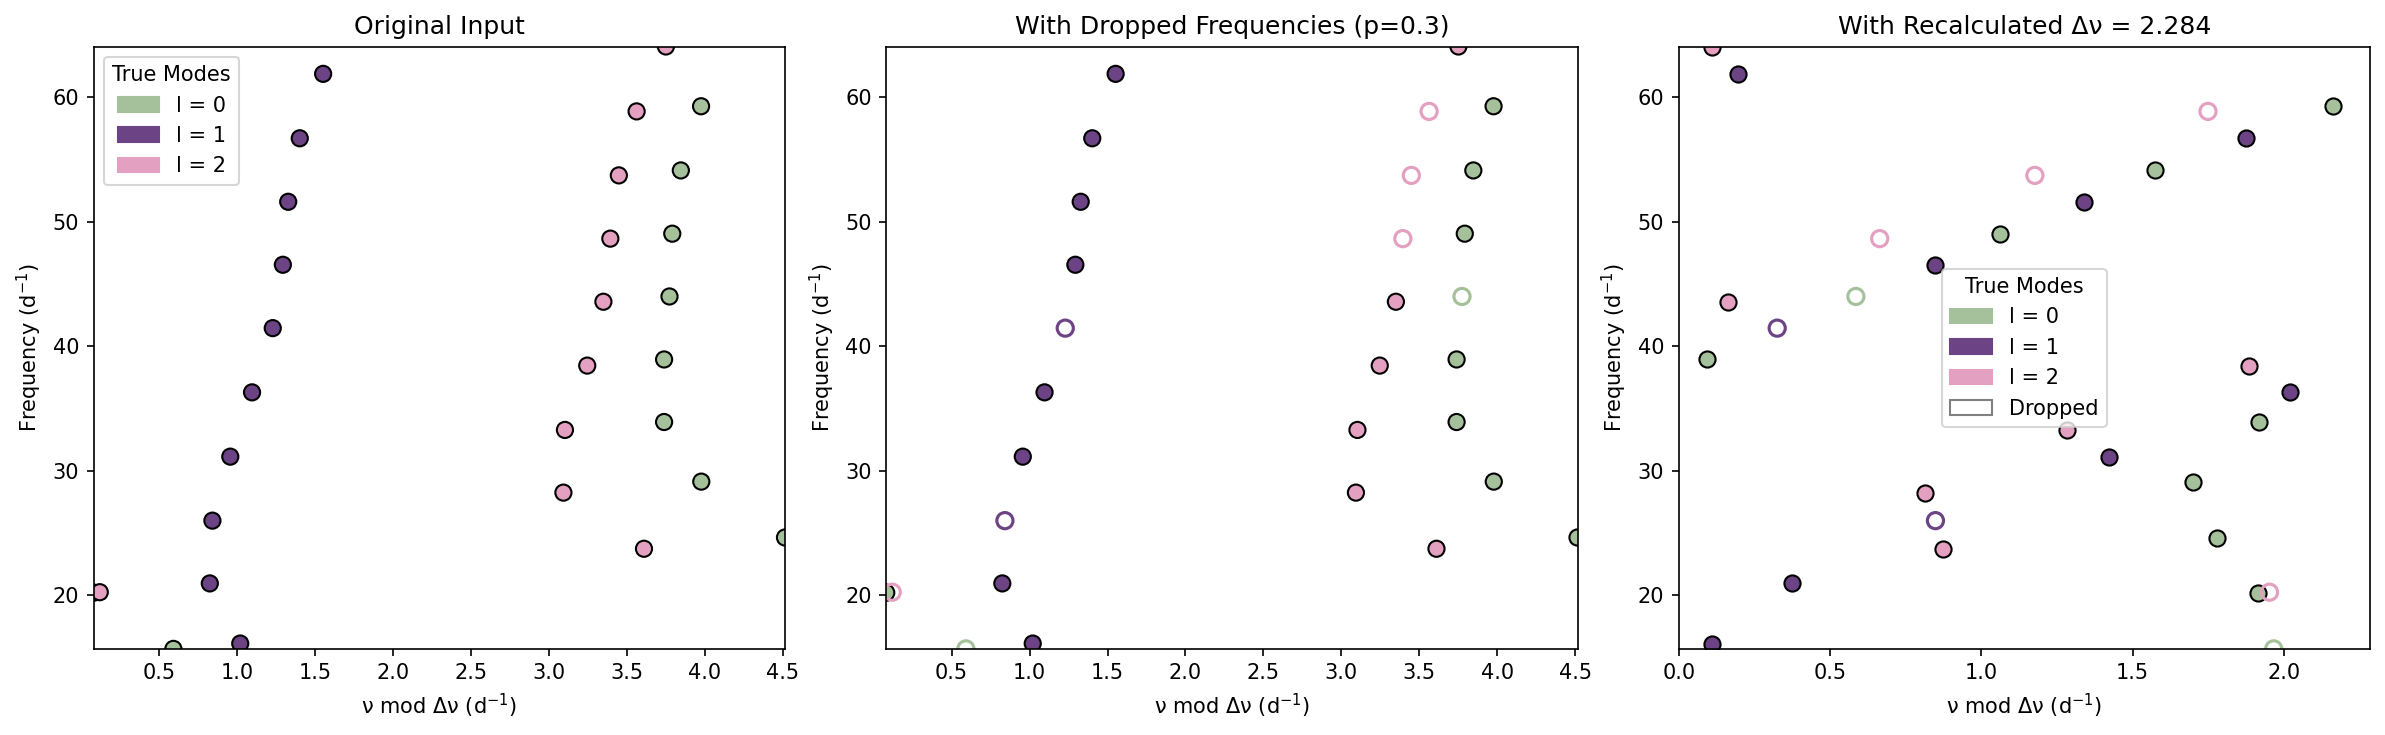

In [15]:
import torch
import matplotlib.pyplot as plt
import random
import matplotlib.patches as mpatches
import numpy as np

def apply_data_dropper(x, y, dropout_prob=0.3):
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()
    x_dropped = x.clone()
    x_dropped[mask == 0] = 0.0
    y_dropped = y.clone()
    y_dropped[mask == 0] = 3  # use 3 for dropped class
    drop_stats = mask.shape[1] - mask.sum(dim=1)
    return x_dropped, y_dropped, mask, drop_stats

def plot_dropped_example(inpt, y_train, dropout_prob=0.5):
    rand_idx = random.randint(0, inpt.shape[0] - 1)
    x_example = inpt[rand_idx:rand_idx+1]
    y_example = y_train[rand_idx:rand_idx+1]

    #print(x_example)
    x_dropped, y_dropped, mask, _ = apply_data_dropper(x_example, y_example, dropout_prob=dropout_prob)

    x_orig = x_example.squeeze(0)
    x_drop = x_dropped.squeeze(0)
    y_orig = y_example.squeeze(0)
    y_drop = y_dropped.squeeze(0)
    mask = mask.squeeze(0)

    color_map = {
        0: '#a5c19b',  # greenish
        1: '#6c4385',  # purple
        2: '#e3a0c0',  # pink
        3: '#aaaaaa',  # gray for dropped
    }
    dnu_original = grid["delta_nu"].iloc[rand_idx]
    print(rf"Original Δν from grid: {dnu_original:.4f} d⁻¹")
    
    xlim = [x_orig[:, 1].min().item(), x_orig[:, 1].max().item()]
    ylim = [x_orig[:, 0].min().item(), x_orig[:, 0].max().item()]

    fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=150)

    # Panel 1: Original Frequencies
    axs[0].scatter(
        x_orig[:, 1], x_orig[:, 0],
        c=[color_map[int(l.item())] for l in y_orig],
        edgecolors='black', s=60
    )
    legend_handles = [mpatches.Patch(color=color_map[i], label=f"l = {i}") for i in range(3)]
    axs[0].legend(handles=legend_handles, loc='best', title="True Modes")

    axs[0].set_title("Original Input")
    axs[0].set_xlabel("ν mod Δν (d$^{-1}$)")
    axs[0].set_ylabel("Frequency (d$^{-1}$)")
    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)

    # Panel 2: Dropped Frequencies
    keep_mask = mask.bool()
    drop_mask = ~keep_mask

    axs[1].scatter(
        x_drop[keep_mask, 1], x_drop[keep_mask, 0],
        c=[color_map[int(y_drop[i].item())] for i in range(len(y_drop)) if keep_mask[i]],
        edgecolors='black', s=60
    )

    for i in range(len(x_drop)):
        if drop_mask[i]:
            true_label = int(y_orig[i].item())
            axs[1].scatter(
                x_orig[i, 1].item(), x_orig[i, 0].item(),
                facecolors='none',
                edgecolors=color_map[true_label],
                linewidths=1.5,
                s=60,
                marker='o'
            )

    axs[1].set_title(f"With Dropped Frequencies (p={dropout_prob})")
    axs[1].set_xlabel("ν mod Δν (d$^{-1}$)")
    axs[1].set_ylabel("Frequency (d$^{-1}$)")
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)

    # Panel 3: Recalculated Δν 
    kept_freqs = x_drop[keep_mask, 0]
    sorted_freqs, _ = torch.sort(kept_freqs)
    if len(sorted_freqs) > 1:
        dnu_recalc = torch.diff(sorted_freqs).mean().item()
    else:
        dnu_recalc = 1.0  
    print(f"Recalculated Δν: {dnu_recalc:.4f}")

    for i in range(len(x_drop)):
        freq = x_orig[i, 0].item()
        mod_freq = freq % dnu_recalc
        if keep_mask[i]:
            axs[2].scatter(
                mod_freq, freq,
                c=color_map[int(y_drop[i].item())],
                edgecolors='black',
                s=60
            )
        else:
            true_label = int(y_orig[i].item())
            axs[2].scatter(
                mod_freq, freq,
                facecolors='none',
                edgecolors=color_map[true_label],
                linewidths=1.5,
                s=60,
                marker='o'
            )

    axs[2].set_title(f"With Recalculated Δν = {dnu_recalc:.3f}")
    axs[2].set_xlabel("ν mod Δν (d$^{-1}$)")
    axs[2].set_ylabel("Frequency (d$^{-1}$)")
    axs[2].set_xlim(0, dnu_recalc)
    axs[2].set_ylim(ylim)
    legend_handles = [mpatches.Patch(color=color_map[i], label=f"l = {i}") for i in range(3)]
    legend_handles.append(mpatches.Patch(facecolor='none', edgecolor='gray', label="Dropped"))
    axs[2].legend(handles=legend_handles, loc='best', title="True Modes")
    plt.tight_layout()
    plt.show()

plot_dropped_example(inpt, y_train, dropout_prob=0.3)

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
i_data = 50
l = 1  # which mode (l=0,1,2) to plot probability for, or fake l=3

# Get the data
freqs = inpt.detach().numpy()[i_data, :, 1]
powers = inpt.detach().numpy()[i_data, :, 0]
true_labels = y_train.detach().numpy()[i_data]
probs = seg_out_test.exp().detach().numpy()[i_data, :, l]

# === First figure: True labels with custom legend ===
fig1 = plt.figure(figsize=(6, 5), dpi=120)
plt.scatter(freqs, powers, c=true_labels, cmap='viridis', vmin=0, vmax=2)

legend_elements = [
    mpatches.Patch(color=plt.cm.viridis(0.0), label='l = 0'),
    mpatches.Patch(color=plt.cm.viridis(0.5), label='l = 1'),
    mpatches.Patch(color=plt.cm.viridis(1.0), label='l = 2'),
]
plt.legend(handles=legend_elements, title="True l-mode", loc="upper right")
plt.title("True Mode Labels")
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)")
plt.ylabel(r"Frequency (d$^{-1}$)")

# === Second figure: Predicted probability for l ===
fig2 = plt.figure(figsize=(6, 5), dpi=120)
sc = plt.scatter(freqs, powers, c=probs, cmap='viridis', vmin=0.0, vmax=1.0)

# Add text labels slightly to the right of each point
for x, y, p in zip(freqs, powers, probs):
    plt.text(x + 0.08, y, f"{p:.2f}", fontsize=7, color="black", ha='left', va='center')

cbar = plt.colorbar(sc)
cbar.set_label(f"Probabilities for l = {l}", fontsize=11, labelpad=10)
cbar.ax.tick_params(labelsize=10)
plt.title(f"Predicted Probabilities (l = {l})")
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)")
plt.ylabel(r"Frequency (d$^{-1}$)")
plt.tight_layout()
plt.show()

NameError: name 'seg_out_test' is not defined

In [ ]:
# of course we still want to know what the distribution of dropped frequencies looks like 

import matplotlib.pyplot as plt

plt.hist(all_drop_counts, bins=25, density=True)
plt.xlabel("Dropped points per sample")
plt.ylabel("Frequency")
plt.title("Histogram of Dropped Points")
plt.grid(True)
plt.show()

#### Only shaker

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def add_noise(x, noise_std=0.2):
    """
    teeny tiny RANDOM Gaussian noise to inputs.
    """
    noise = torch.randn_like(x) * noise_std
    return x + noise

Nepoch = 150
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size(0) // nbatches

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean", ignore_index=-1)

history_train, history_test = [], []

inpt_test = inpt
target_test = y_train[:inpt.shape[0]]

for epoch in range(Nepoch):
    model.train()
    for i in range(nbatches):
        optimizer.zero_grad()
        x_batch = X_train[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        x_noisy = add_noise(x_batch, noise_std=0.05)
        seg_output = model(x_noisy)
        seg_output = seg_output.permute(0, 2, 1)
        loss = loss_fn(seg_output, y_batch)
        cost = loss.mean()
        cost.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        seg_out_test = model(inpt_test)
        cost_test = loss_fn(seg_out_test.permute(0, 2, 1), target_test)

    history_train.append(float(cost))
    history_test.append(float(cost_test))
    print(f"Epoch {epoch}: Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}")

In [ ]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()

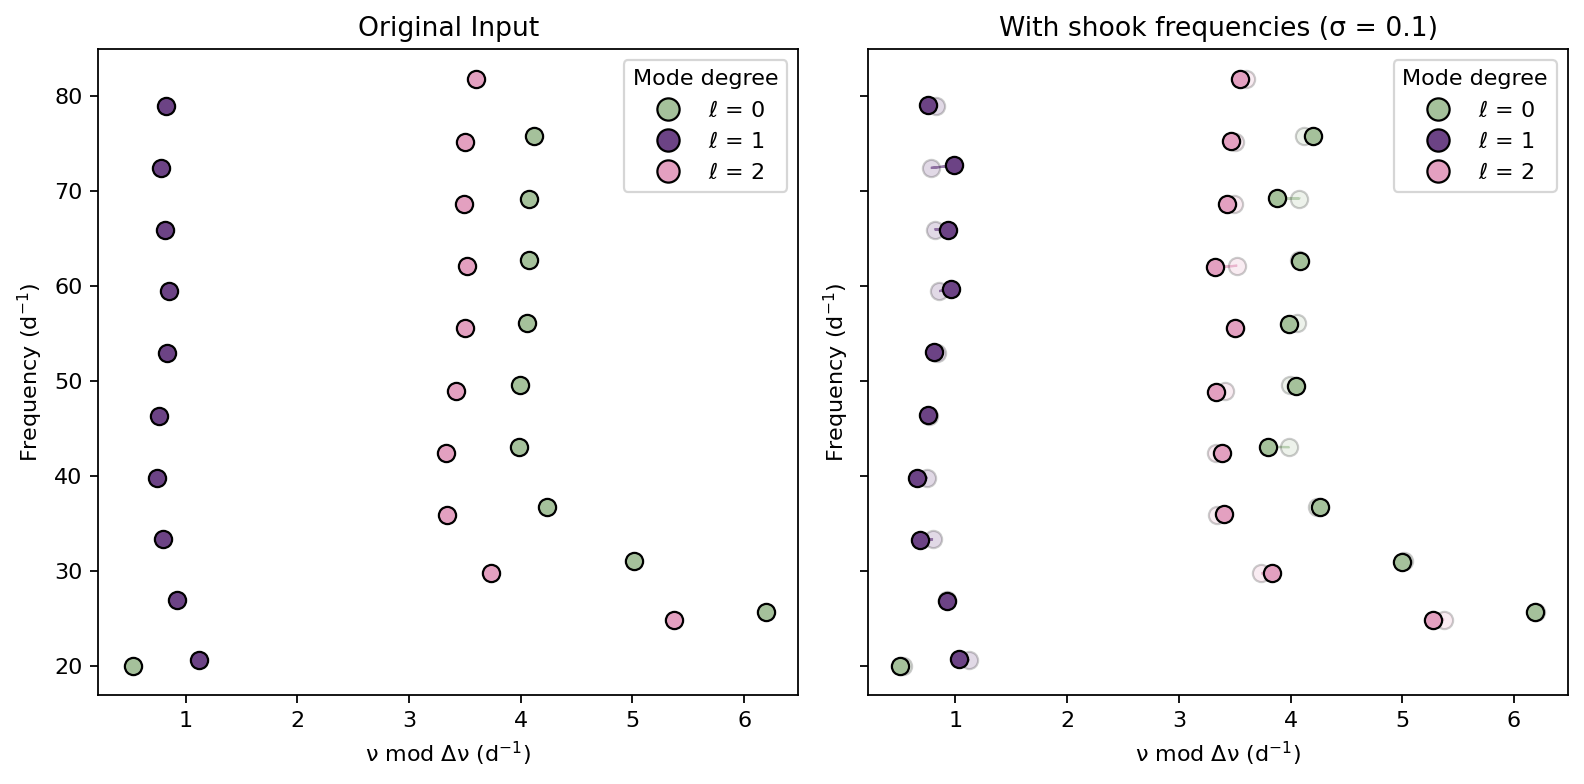

In [18]:
import matplotlib.pyplot as plt
import random

def add_noise(x, noise_std=0.2):
    """
    teeny tiny RANDOM Gaussian noise to inputs.
    """
    noise = torch.randn_like(x) * noise_std
    return x + noise


def plot_shaker_example(X_train, y_train, noise_std=0.05):
    """
    Side-by-side view of original vs. noise-shaken frequencies.
    """
    rand_idx = random.randint(0, X_train.shape[0] - 1)
    x_orig = X_train[rand_idx].clone()
    y_orig = y_train[rand_idx]
    x_noisy = add_noise(x_orig.unsqueeze(0), noise_std=noise_std).squeeze(0)

    color_map = {
        0: '#a5c19b',  # green (l=0)
        1: '#6c4385',  # purple (l=1)
        2: '#e3a0c0',  # pink (l=2)
        3: '#cccccc',  # gray (optional class)
    }

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=160, sharex=True, sharey=True)

    for i in range(x_orig.shape[0]):
        label = int(y_orig[i].item())
        color = color_map.get(label, "#000000")

        axes[0].scatter(x_orig[i, 1], x_orig[i, 0],
                        s=60, edgecolors="black", facecolors=color, zorder=3)

        axes[1].scatter(x_orig[i, 1], x_orig[i, 0],
                        s=60, edgecolors="black", facecolors=color, alpha=0.2, zorder=3)
        axes[1].arrow(x_orig[i, 1], x_orig[i, 0],
                          dx=x_noisy[i, 1] - x_orig[i, 1],
                          dy=x_noisy[i, 0] - x_orig[i, 0],
                          color=color, alpha=0.7, head_width=0.003,
                          length_includes_head=True, zorder=2)
        axes[1].scatter(x_noisy[i, 1], x_noisy[i, 0],
                            s=60, edgecolors="black", facecolors=color, zorder=3)

    axes[0].set_title("Original Input")
    axes[1].set_title(f"With shook frequencies (σ = {noise_std})")

    for ax in axes:
        ax.set_xlabel("ν mod Δν (d$^{-1}$)")
        ax.set_ylabel("Frequency (d$^{-1}$)")

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[i],
                   markeredgecolor='black', markersize=10, label=rf"$\ell$ = {i}")
        for i in sorted(set(y_orig.tolist())) if i in color_map
    ]
    axes[0].legend(handles=handles, title="Mode degree", loc="best")
    axes[1].legend(handles=handles, title="Mode degree", loc="best")

    plt.tight_layout()
    plt.savefig("shaker_example_mindset.pdf", bbox_inches="tight")
    plt.show()


plot_shaker_example(X_train, y_train, noise_std=0.1)

#### Now shaker and dropper!!

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


def apply_data_dropper(x, y, dropout_prob=0.3):
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()

    x_dropped = x.clone()
    x_dropped[mask == 0] = 0.0

    y_dropped = y.clone()
    y_dropped[mask == 0] = 3  # new label for dropped points = 3

    drop_stats = mask.shape[1] - mask.sum(dim=1)
    return x_dropped, y_dropped, mask, drop_stats

def add_noise(x, noise_std=0.2):
    """
    teeny tiny RANDOM Gaussian noise to inputs.
    """
    noise = torch.randn_like(x) * noise_std
    return x + noise


Nepoch = 150
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size(0) // nbatches

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean")  # ← REMOVED ignore_index
history_train, history_test = [], []
all_drop_counts = []
inpt_test = inpt
target_test = y_train[:inpt.shape[0]]

for epoch in range(Nepoch):
    model.train()

    for i in range(nbatches):
        optimizer.zero_grad()

        x_batch = inpt[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        x_dropped, y_dropped, mask, drop_stats = apply_data_dropper(x_batch, y_batch, dropout_prob=0.3)
        all_drop_counts.extend(drop_stats.cpu().tolist())

        x_dropped = add_noise(x_dropped, noise_std=0.2)

        seg_output = model(x_dropped)
        cost = loss_fn(seg_output.permute(0, 2, 1), y_dropped)

        cost.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        seg_out_test = model(inpt_test)
        cost_test = loss_fn(seg_out_test.permute(0, 2, 1), target_test)

    history_train.append(float(cost))
    history_test.append(float(cost_test))
    pred_classes = seg_out_test.argmax(dim=2)
    mask_valid = target_test != 3
    acc = (pred_classes[mask_valid] == target_test[mask_valid]).float().mean()
    print(f"Accuracy = {acc:.4f}")

    print(f"Epoch {epoch}: Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}")

Accuracy = 0.8799
Epoch 0: Train Loss = 0.3056, Test Loss = 0.3137
Accuracy = 0.8824
Epoch 1: Train Loss = 0.3055, Test Loss = 0.3168


KeyboardInterrupt: 

In [ ]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()

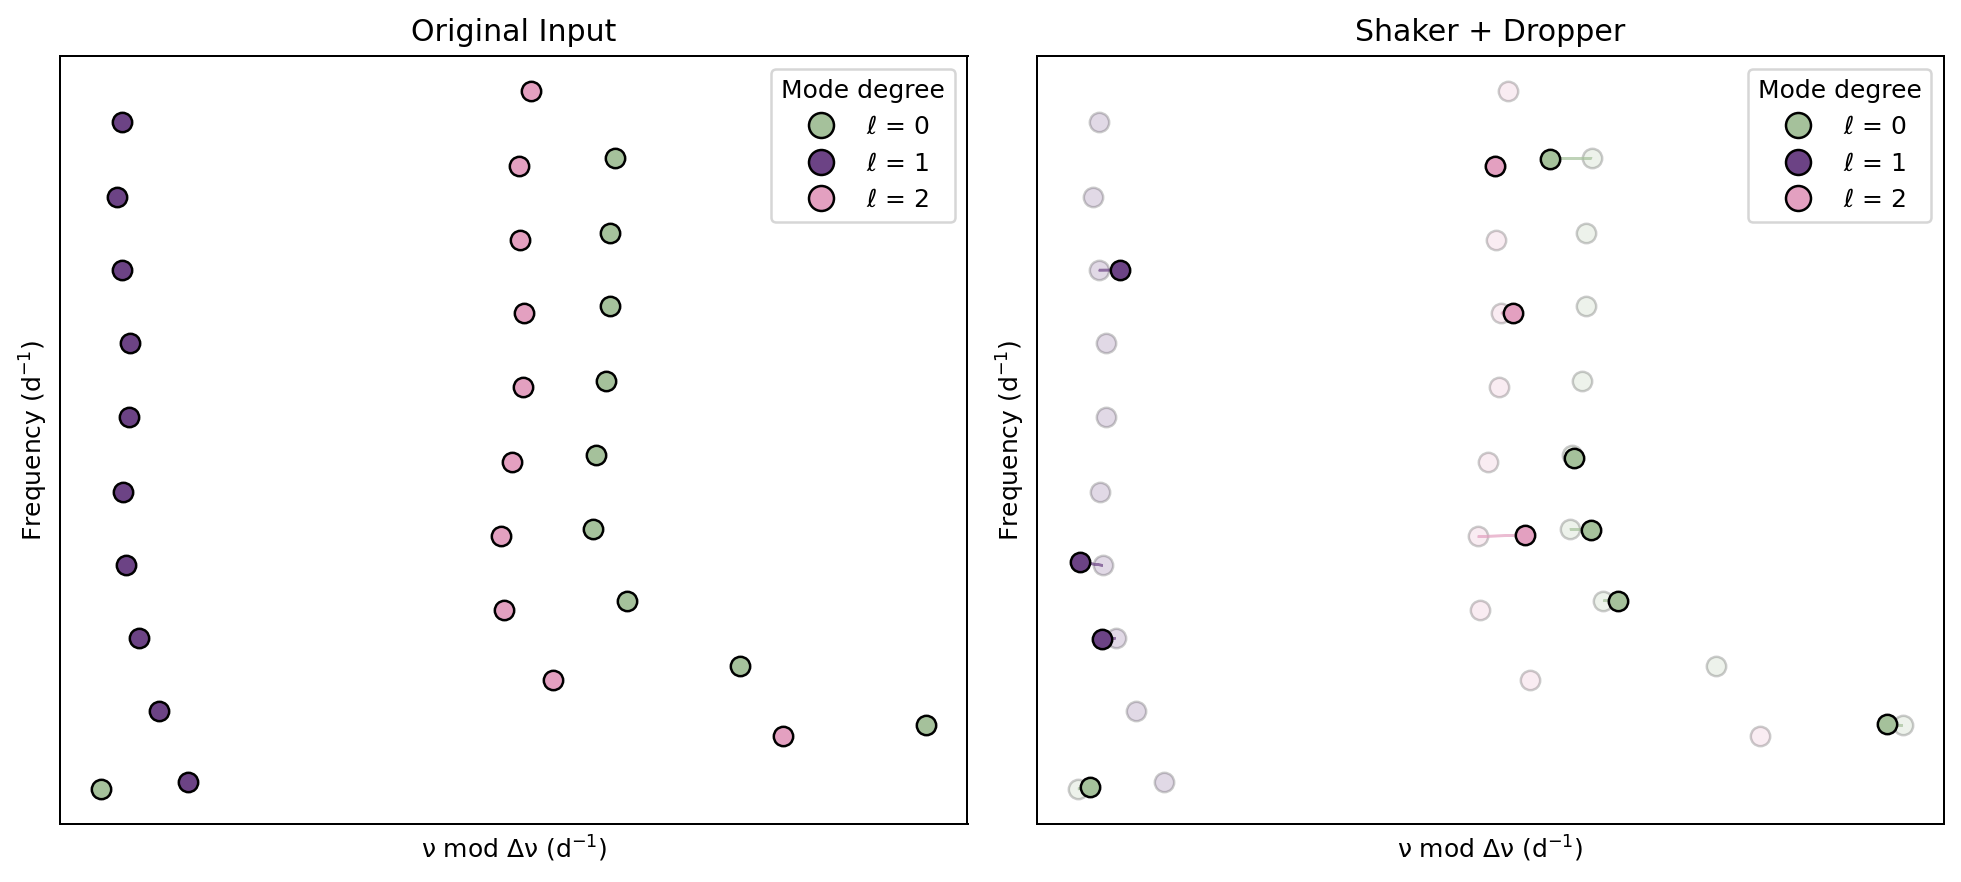

In [13]:
import matplotlib.pyplot as plt
import torch
import random

def plot_shaker_dropper(X_train, y_train, dropout_prob=0.3, noise_std=0.05):
    rand_idx = random.randint(0, X_train.shape[0] - 1)
    x_orig = X_train[rand_idx].clone()
    y_orig = y_train[rand_idx].clone()

    # Decide which frequencies to drop
    keep_mask = torch.rand(x_orig.shape[0]) > dropout_prob

    # Apply dropout
    x_dropped = x_orig.clone()
    y_dropped = y_orig.clone()
    y_dropped[~keep_mask] = -1  # mark dropped

    # Apply Gaussian noise only to the kept points
    x_noisy = x_dropped.clone()
    x_noisy[keep_mask] += torch.randn_like(x_noisy[keep_mask]) * noise_std

    # Color map for mode degrees
    color_map = {
        0: '#a5c19b',  # green
        1: '#6c4385',  # purple
        2: '#e3a0c0',  # pink
    }

    fig, axes = plt.subplots(1, 2, figsize=(11, 5), dpi=180, sharex=True, sharey=True)

    # LEFT: Original frequencies
    for i in range(x_orig.shape[0]):
        label = int(y_orig[i].item())
        if label in color_map:
            axes[0].scatter(x_orig[i, 1], x_orig[i, 0],
                            s=60, edgecolors="black", facecolors=color_map[label], zorder=3)

    axes[0].set_title("Original Input")

    # RIGHT: Shaken + Dropped
    for i in range(x_orig.shape[0]):
        label = int(y_orig[i].item())
        if label not in color_map:
            continue
        color = color_map[label]

        # Always draw ghost dot at original position
        axes[1].scatter(x_orig[i, 1], x_orig[i, 0],
                        s=60, edgecolors="black", facecolors=color, alpha=0.2, zorder=1)

        if keep_mask[i]:
            # SHAKEN: arrow + updated dot
            axes[1].arrow(x_orig[i, 1], x_orig[i, 0],
                          dx=x_noisy[i, 1] - x_orig[i, 1],
                          dy=x_noisy[i, 0] - x_orig[i, 0],
                          color=color, alpha=0.7, head_width=0.003,
                          length_includes_head=True, zorder=2)
            axes[1].scatter(x_noisy[i, 1], x_noisy[i, 0],
                            s=60, edgecolors="black", facecolors=color, zorder=3)

    axes[1].set_title("Shaker + Dropper")

    for ax in axes:
        ax.set_xlabel("ν mod Δν (d$^{-1}$)")
        ax.set_ylabel("Frequency (d$^{-1}$)")
        ax.set_xticks([])
        ax.set_yticks([])

    # Shared legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=color_map[i], markeredgecolor='black',
                   markersize=10, label=rf"$\ell$ = {i}")
        for i in sorted(color_map)
    ]
    for ax in axes:
        ax.legend(handles=handles, title="Mode degree", loc="upper right")

    plt.tight_layout()
    plt.show()

# Example usage
plot_shaker_dropper(X_train, y_train, dropout_prob=0.5, noise_std=0.2)

#### Only faker

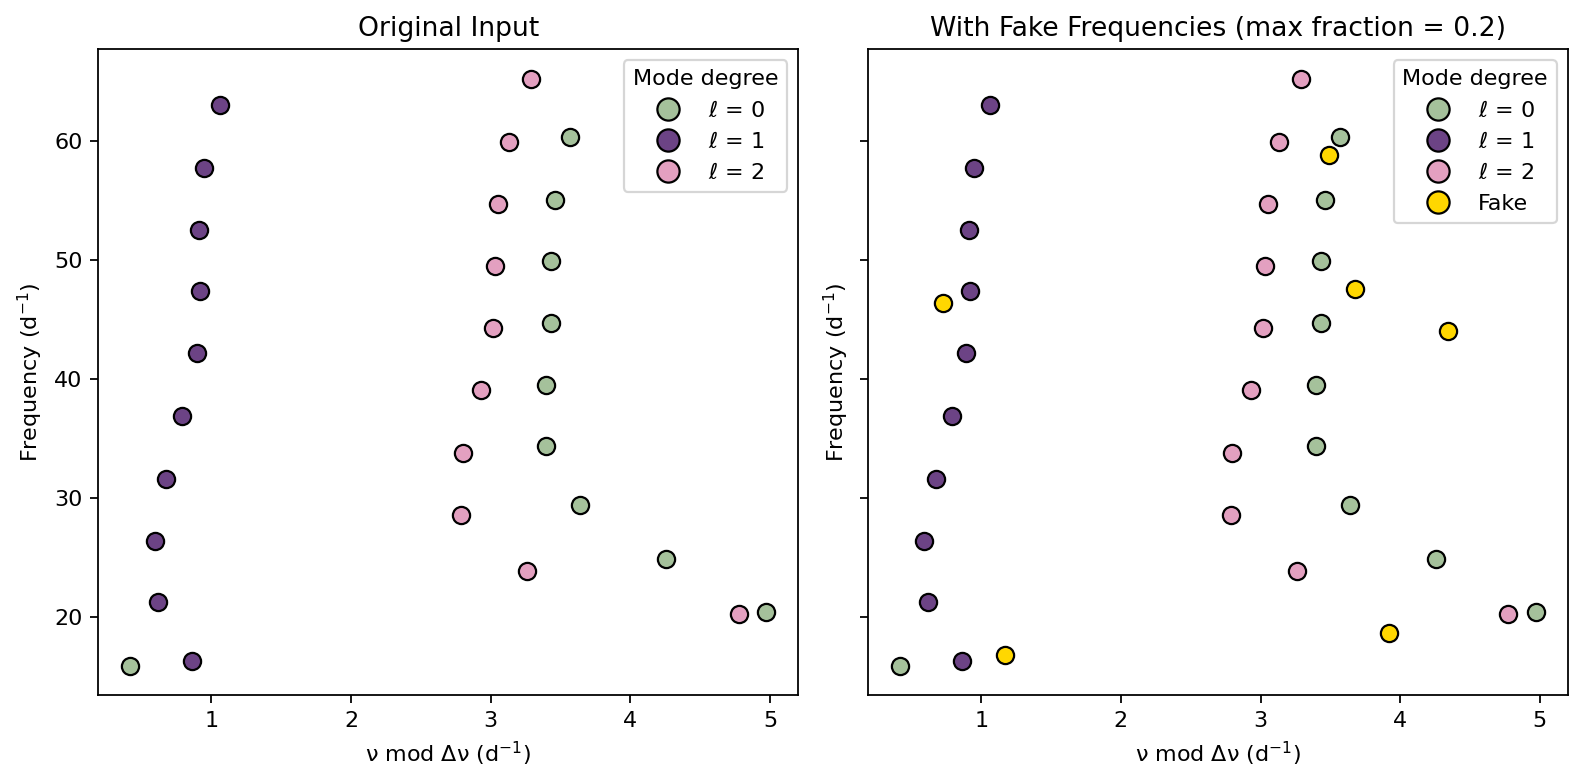

In [23]:
import torch
import matplotlib.pyplot as plt
import random

FAKE_CLASS = 3
DROPPED_CLASS = -1
REAL_CLASSES = [0, 1, 2]
MAX_FAKE_FRACTION = 0.2  # you can tune this

def inject_fake_frequencies(x, y, max_fake_fraction=MAX_FAKE_FRACTION, num_fake_points=10):
    """
    Inject fake frequencies uniformly across the observed ν and ν mod Δν ranges.
    """
    valid_mask = y != DROPPED_CLASS
    x_real = x[valid_mask]
    y_real = y[valid_mask]

    if x_real.shape[0] < 2:
        return x, y, None

    # Estimate Δν and observed mod range
    freqs = x_real[:, 0]
    freqs_sorted, _ = freqs.sort()
    dnu = (freqs_sorted[1:] - freqs_sorted[:-1]).mean().item()

    f_min = freqs.min().item()
    f_max = freqs.max().item()

    mod_vals = x_real[:, 1]
    mod_min = mod_vals.min().item()
    mod_max = mod_vals.max().item()

    # Decide number of fake points
    n_real = x_real.shape[0]
    n_fake = min(num_fake_points, int(n_real * max_fake_fraction))
    if n_fake <= 0:
        return x, y, None

    # Sample uniformly within observed frequency and mod ranges
    f_fake = torch.rand(n_fake, device=x.device) * (f_max - f_min) + f_min
    mod_fake = torch.rand(n_fake, device=x.device) * (mod_max - mod_min) + mod_min

    fake_points = torch.stack([f_fake, mod_fake], dim=1)

    # Append to data
    x_aug = torch.cat([x, fake_points], dim=0)
    y_aug = torch.cat([y, torch.full((n_fake,), FAKE_CLASS, dtype=torch.long, device=x.device)], dim=0)

    return x_aug, y_aug, fake_points


def plot_fake_frequency_injection(x_orig, y_orig, max_fake_fraction=MAX_FAKE_FRACTION):
    """
    Side-by-side comparison of original vs. with fake frequencies.
    """
    x_fake, y_fake, _ = inject_fake_frequencies(x_orig, y_orig, max_fake_fraction=max_fake_fraction)

    color_map = {
        0: '#a5c19b',  # green (l=0)
        1: '#6c4385',  # purple (l=1)
        2: '#e3a0c0',  # pink (l=2)
        3: 'gold',     # fake
    }

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=160, sharex=True, sharey=True)

    # Plot original
    for i in range(x_orig.shape[0]):
        label = int(y_orig[i].item())
        color = color_map.get(label, "#000000")
        axes[0].scatter(x_orig[i, 1], x_orig[i, 0], s=60, edgecolors="black", facecolors=color, zorder=3)
    axes[0].set_title("Original Input")

    # Plot with fakes
    for i in range(x_fake.shape[0]):
        label = int(y_fake[i].item())
        color = color_map.get(label, "#000000")
        axes[1].scatter(x_fake[i, 1], x_fake[i, 0], s=60, edgecolors="black", facecolors=color, zorder=3)
    axes[1].set_title(f"With Fake Frequencies (max fraction = {max_fake_fraction:.1f})")

    for ax in axes:
        ax.set_xlabel("ν mod Δν (d$^{-1}$)")
        ax.set_ylabel("Frequency (d$^{-1}$)")

    # Legend handles for real classes only
    handles_real = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=color_map[i], markeredgecolor='black',
                   markersize=10, label=rf"$\ell$ = {i}")
        for i in REAL_CLASSES
    ]

    # Legend handles including fake
    handles_all = handles_real + [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=color_map[FAKE_CLASS], markeredgecolor='black',
                   markersize=10, label="Fake")
    ]

    axes[0].legend(handles=handles_real, title="Mode degree", loc="best")
    axes[1].legend(handles=handles_all, title="Mode degree", loc="best")

    plt.tight_layout()
    plt.savefig("faker_example_mindset.pdf", bbox_inches="tight")
    plt.show()


# Example usage
rand_idx = random.randint(0, X_train.shape[0] - 1)
x_sample = X_train[rand_idx].clone()
y_sample = y_train[rand_idx].clone()

plot_fake_frequency_injection(x_sample, y_sample, max_fake_fraction=0.2)

Original Δν from grid: 5.2835 d⁻¹
Recalculated Δν from sample: 2.0604 d⁻¹


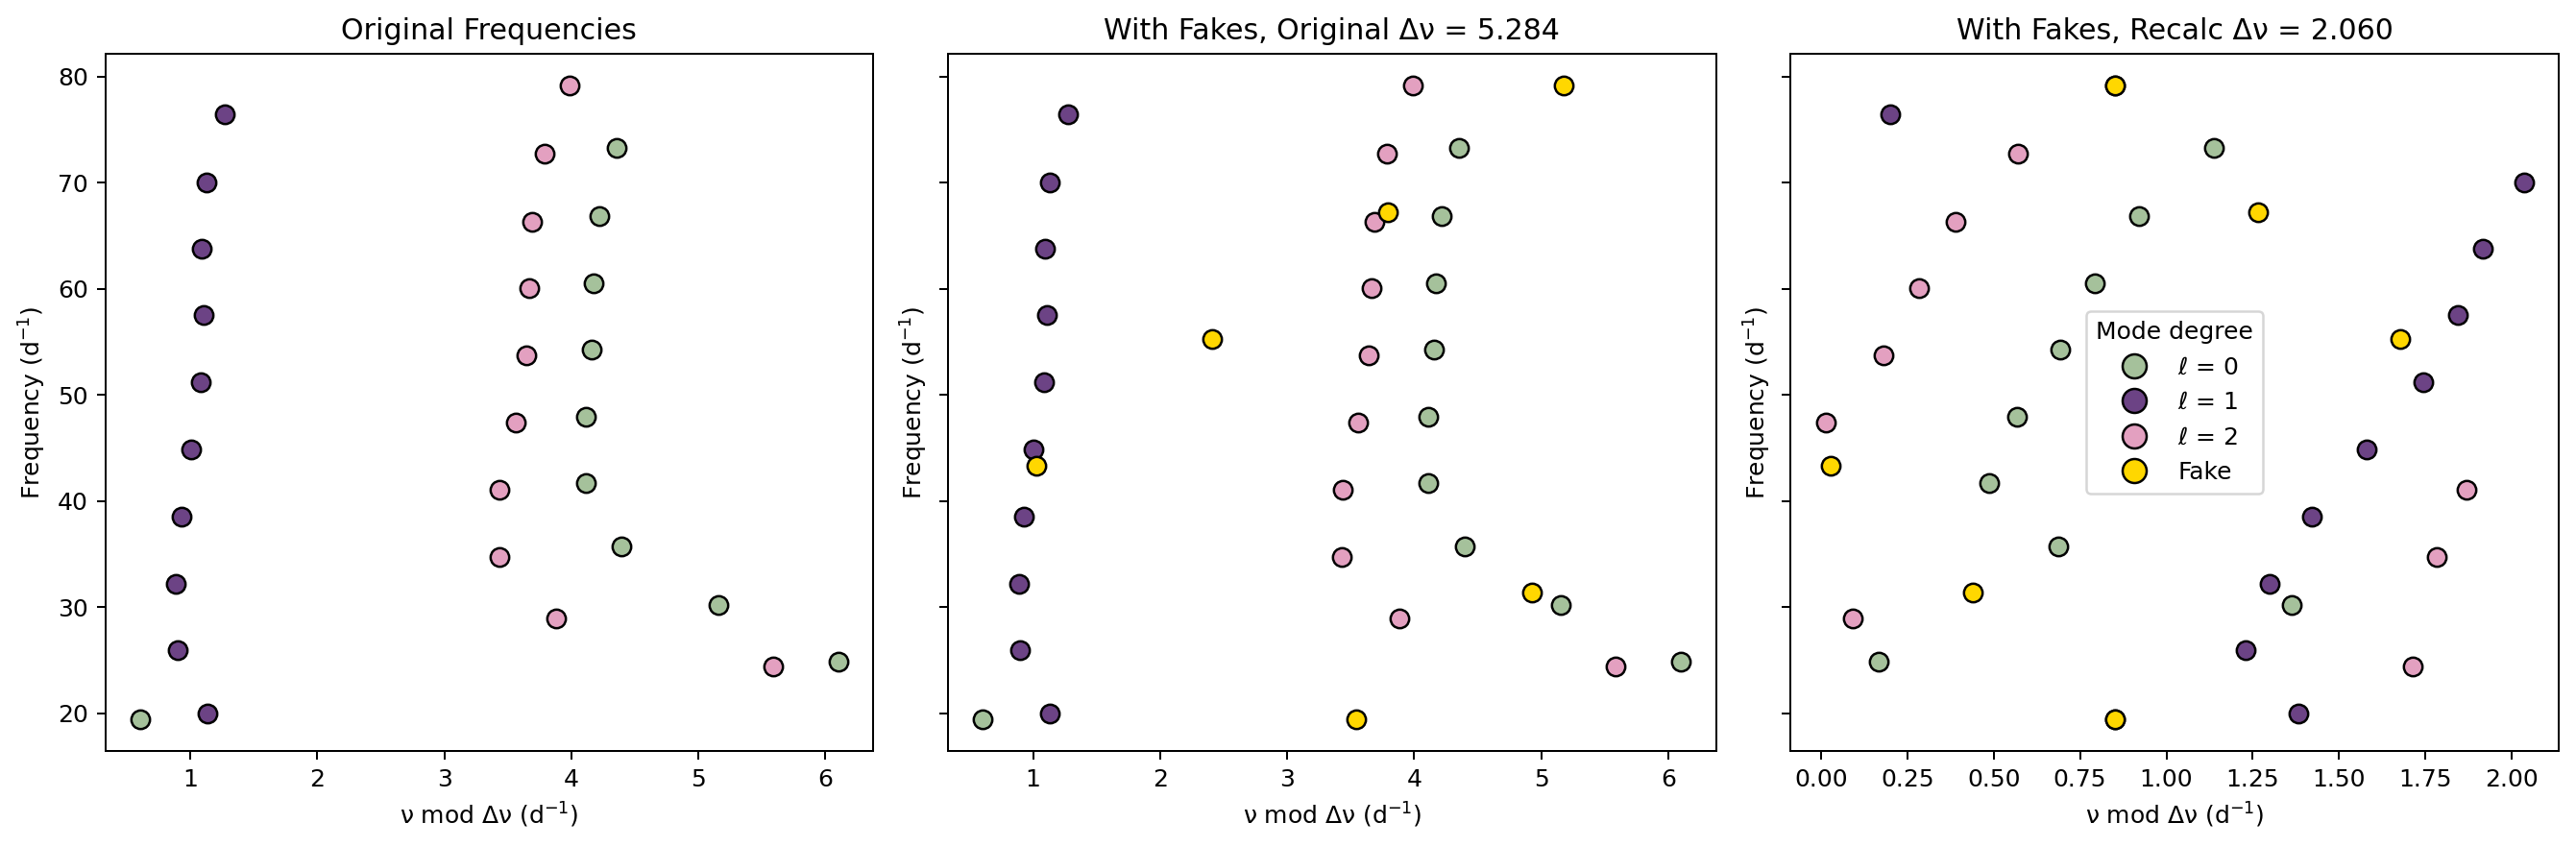

In [15]:
import torch
import matplotlib.pyplot as plt
import random
import pandas as pd

grid = pd.read_pickle("outputs_in_instab_strip.pkl")

def inject_fake_frequencies(x, y, max_fake_fraction=0.2):
    """
    Inject fake frequencies into a single sample.
    """
    num_real = x.shape[0]
    num_fake = int(num_real * max_fake_fraction)

    f_min = x[:, 0].min().item()
    f_max = x[:, 0].max().item()

    # Recalculate Δν from real frequency spacings
    sorted_freqs = x[:, 0].sort()[0]
    dnu_recalc = (sorted_freqs[1:] - sorted_freqs[:-1]).mean().item()

    # Evenly sampled fake frequencies
    fake_freqs = torch.zeros(num_fake, 2)
    fake_freqs[:, 0] = torch.linspace(f_min, f_max, steps=num_fake)
    fake_freqs[:, 1] = fake_freqs[:, 0] % dnu_recalc

    x_aug = torch.cat([x, fake_freqs], dim=0)
    y_aug = torch.cat([y, torch.full((num_fake,), 3)])  # label = 3 for fake
    return x_aug, y_aug, dnu_recalc


def plot_fake_frequency_injection(x_orig, y_orig, rand_idx):
    """
    Compare echelle diagrams with original and recalculated Δν after injecting fake frequencies.
    """
    dnu_original = grid["delta_nu"].iloc[rand_idx]
    print(f"Original Δν from grid: {dnu_original:.4f} d⁻¹")

    x_fake, y_fake, dnu_recalc = inject_fake_frequencies(x_orig, y_orig)
    print(f"Recalculated Δν from sample: {dnu_recalc:.4f} d⁻¹")

    color_map = {
        0: '#a5c19b',  # green (l=0)
        1: '#6c4385',  # purple (l=1)
        2: '#e3a0c0',  # pink (l=2)
        3: 'gold',     # fake
    }

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=180, sharey=True)

    # --- First panel: Original ---
    for i in range(x_orig.shape[0]):
        label = int(y_orig[i].item())
        color = color_map.get(label, "#000000")
        axes[0].scatter(x_orig[i, 1], x_orig[i, 0],
                        s=60, edgecolors="black", facecolors=color, zorder=3)
    axes[0].set_title("Original Frequencies")
    axes[0].set_xlabel("ν mod Δν (d$^{-1}$)")

    # --- Second panel: Original Δν with fake frequencies ---
    for i in range(x_fake.shape[0]):
        label = int(y_fake[i].item())
        color = color_map.get(label, "#000000")
        freq = x_fake[i, 0].item()

        if label == 3:
            mod_val = freq % dnu_original  # compute mod for fake only
        else:
            # Use precomputed ν mod Δν stored in x_orig
            # Match by frequency value (float match should be safe here since it’s from original)
            match_idx = (x_orig[:, 0] == freq).nonzero(as_tuple=True)[0]
            if len(match_idx) > 0:
                mod_val = x_orig[match_idx[0], 1].item()
            else:
                # fallback if exact match not found
                mod_val = freq % dnu_original

        axes[1].scatter(mod_val, freq,
                        s=60, edgecolors="black", facecolors=color, zorder=3)

    axes[1].set_title(f"With Fakes, Original Δν = {dnu_original:.3f}")
    axes[1].set_xlabel("ν mod Δν (d$^{-1}$)")

    # --- Third panel: Recalculated Δν applied to all ---
    for i in range(x_fake.shape[0]):
        label = int(y_fake[i].item())
        color = color_map.get(label, "#000000")
        freq = x_fake[i, 0].item()
        mod_val = freq % dnu_recalc
        axes[2].scatter(mod_val, freq,
                        s=60, edgecolors="black", facecolors=color, zorder=3)

    axes[2].set_title(f"With Fakes, Recalc Δν = {dnu_recalc:.3f}")
    axes[2].set_xlabel("ν mod Δν (d$^{-1}$)")

    for ax in axes:
        ax.set_ylabel("Frequency (d$^{-1}$)")

    # Legend on third panel
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[i],
                   markeredgecolor='black', markersize=10, label=rf"$\ell$ = {i}" if i < 3 else "Fake")
        for i in sorted(set(y_fake.tolist()))
    ]
    axes[2].legend(handles=handles, title="Mode degree", loc="best")

    plt.tight_layout()
    plt.show()


rand_idx = random.randint(0, X_train.shape[0] - 1)
x_sample = X_train[rand_idx].clone()
y_sample = y_train[rand_idx].clone()

plot_fake_frequency_injection(x_sample, y_sample, rand_idx)

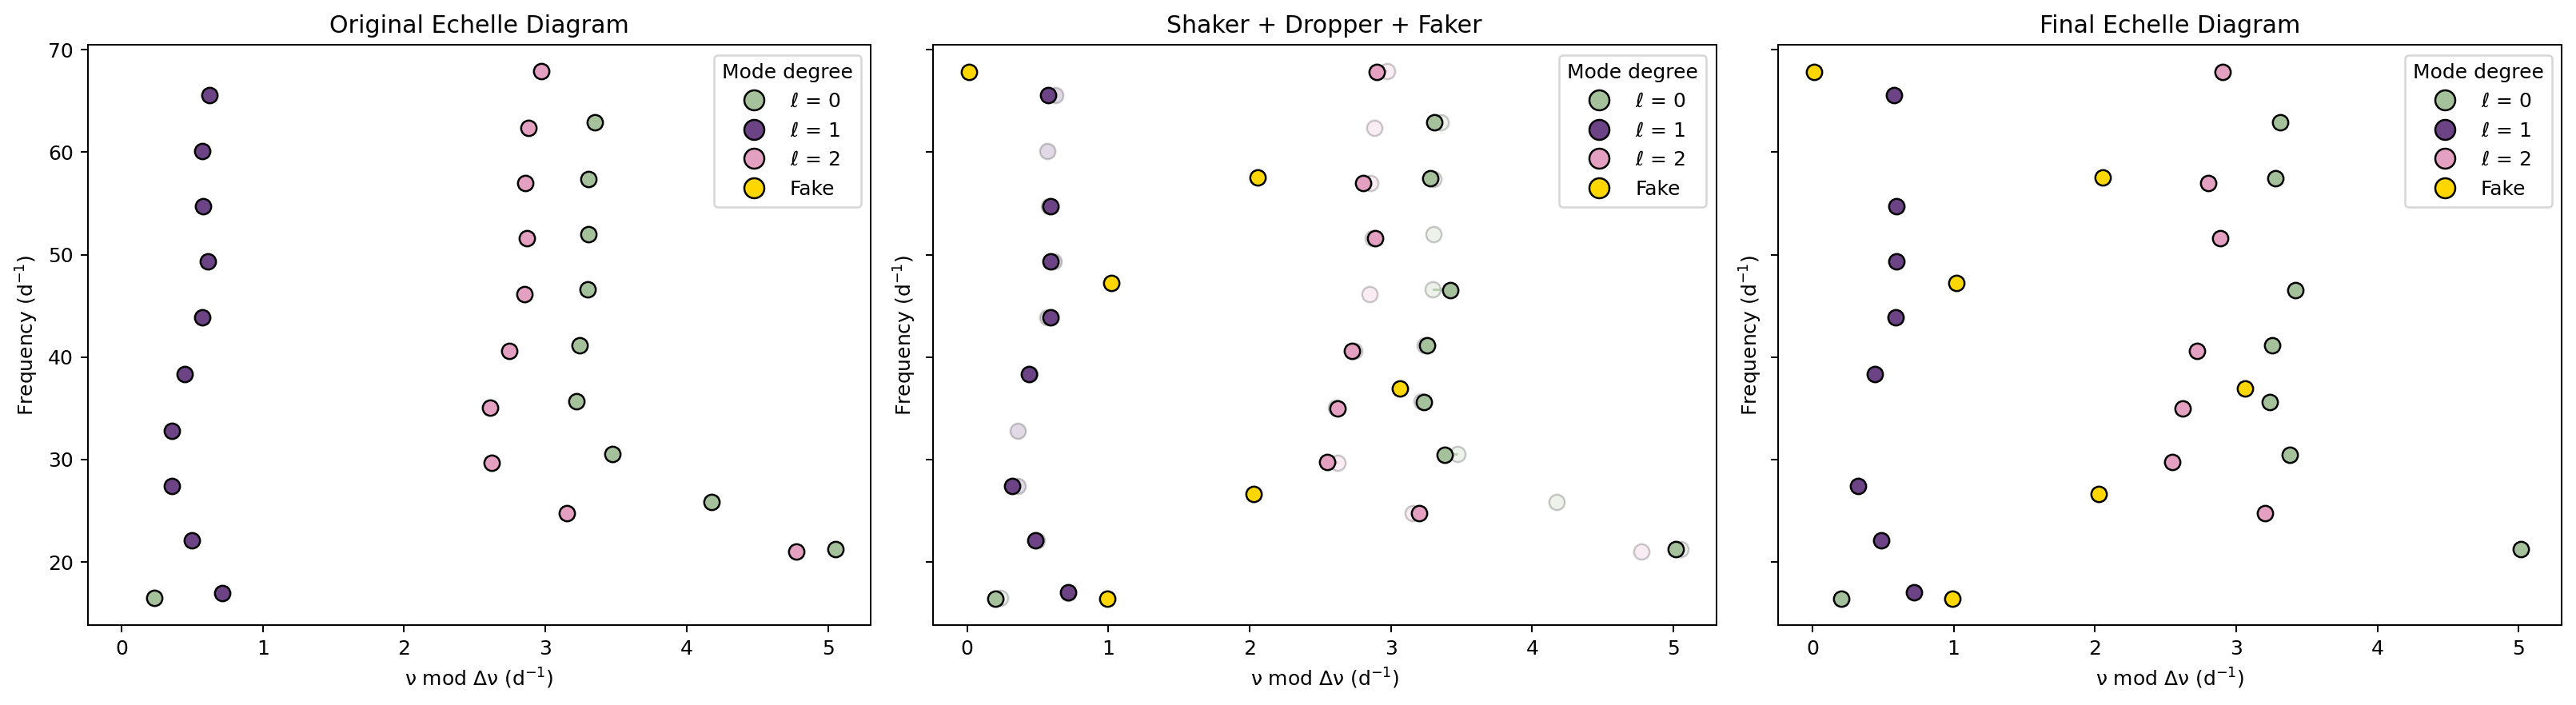

In [25]:
import matplotlib.pyplot as plt
import torch
import random
import pandas as pd

grid = pd.read_pickle("outputs_in_instab_strip.pkl")

def inject_fake_frequencies(x, y, dnu_mod, max_fake_fraction=0.2):
    """
    Inject fake frequencies into a sample using a fixed Δν for mod spacing.
    """
    num_real = x.shape[0]
    num_fake = int(num_real * max_fake_fraction)

    f_min = x[:, 0].min().item()
    f_max = x[:, 0].max().item()

    # Evenly sampled fake frequencies
    fake_freqs = torch.zeros(num_fake, 2)
    fake_freqs[:, 0] = torch.linspace(f_min, f_max, steps=num_fake)
    fake_freqs[:, 1] = fake_freqs[:, 0] % dnu_mod

    x_aug = torch.cat([x, fake_freqs], dim=0)
    y_aug = torch.cat([y, torch.full((num_fake,), 3)])  # label = 3 for fake
    return x_aug, y_aug

def plot_combined_augmentation(X_train, y_train, dropout_prob=0.3, noise_std=0.05, fake_frac=0.2):
    rand_idx = random.randint(0, X_train.shape[0] - 1)
    x_orig = X_train[rand_idx].clone()
    y_orig = y_train[rand_idx].clone()

    # Get Δν from the grid
    dnu_grid = grid["delta_nu"].iloc[rand_idx]  # assumed in μHz
   
    # DROPPER 
    keep_mask = torch.rand(x_orig.shape[0]) > dropout_prob
    x_dropped = x_orig.clone()
    y_dropped = y_orig.clone()
    y_dropped[~keep_mask] = -1  # mark dropped

    # SHAKER 
    x_shaken = x_dropped.clone()
    x_shaken[keep_mask] += torch.randn_like(x_shaken[keep_mask]) * noise_std

    # FAKER using grid Δν
    x_fake, y_fake = inject_fake_frequencies(x_shaken, y_dropped, dnu_mod=dnu_grid, max_fake_fraction=fake_frac)

    color_map = {
        0: '#a5c19b',  # l=0
        1: '#6c4385',  # l=1
        2: '#e3a0c0',  # l=2
        3: 'gold',     # fake
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=180, sharex=True, sharey=True)

    # PANEL 1: ORIGINAL
    for i in range(x_orig.shape[0]):
        label = int(y_orig[i].item())
        if label in color_map:
            axes[0].scatter(x_orig[i, 1], x_orig[i, 0], s=60,
                            edgecolors="black", facecolors=color_map[label], zorder=3)
    axes[0].set_title("Original Echelle Diagram")

    # PANEL 2: Shaker + Dropper + Faker (with arrows + ghosts)
    for i in range(x_orig.shape[0]):
        label = int(y_orig[i].item())
        if label not in color_map:
            continue
        color = color_map[label]

        # Ghost
        axes[1].scatter(x_orig[i, 1], x_orig[i, 0], s=60,
                        edgecolors="black", facecolors=color, alpha=0.2, zorder=1)

        if keep_mask[i]:
            # Arrow
            axes[1].arrow(x_orig[i, 1], x_orig[i, 0],
                          dx=x_shaken[i, 1] - x_orig[i, 1],
                          dy=x_shaken[i, 0] - x_orig[i, 0],
                          color=color, alpha=0.7, head_width=0.003,
                          length_includes_head=True, zorder=2)
            # Shaken
            axes[1].scatter(x_shaken[i, 1], x_shaken[i, 0], s=60,
                            edgecolors="black", facecolors=color, zorder=3)

    # Fake frequencies
    for i in range(x_fake.shape[0]):
        label = int(y_fake[i].item())
        if label == 3:
            axes[1].scatter(x_fake[i, 1], x_fake[i, 0], s=60,
                            edgecolors="black", facecolors=color_map[3], zorder=4)

    axes[1].set_title("Shaker + Dropper + Faker")

    # PANEL 3: Final (no ghosts or arrows)
    for i in range(x_fake.shape[0]):
        label = int(y_fake[i].item())
        if label in color_map:
            axes[2].scatter(x_fake[i, 1], x_fake[i, 0], s=60,
                            edgecolors="black", facecolors=color_map[label], zorder=3)
    axes[2].set_title("Final Echelle Diagram")

    # shared formatting
    for ax in axes:
        ax.set_xlabel("ν mod Δν (d$^{-1}$)")
        ax.set_ylabel("Frequency (d$^{-1}$)")

        handles = [
            plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=color_map[i], markeredgecolor='black',
                       markersize=10, label=rf"$\ell$ = {i}" if i < 3 else "Fake")
            for i in color_map
        ]
        ax.legend(handles=handles, title="Mode degree", loc="best")

    plt.tight_layout()
    plt.show()

# Call the function
plot_combined_augmentation(X_train, y_train, dropout_prob=0.2, noise_std=0.05, fake_frac=0.2)